# 1 Columns - Definition

The time period for this data is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA.   
No: row number   
year: year of data in this row   
month: month of data in this row   
day: day of data in this row    
hour: hour of data in this row   
season: season of data in this row    
PM: PM2.5 concentration (ug/m^3)    
DEWP: Dew Point (Celsius Degree)    
TEMP: Temperature (Celsius Degree)    
HUMI: Humidity (%)    
PRES: Pressure (hPa)    
cbwd: Combined wind direction    
Iws: Cumulated wind speed (m/s)    
precipitation: hourly precipitation (mm)    
Iprec: Cumulated precipitation (mm)

# 2 Load and prepare the data

### 2.1 Import Package

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pwd
%ls

Final Presentation-PM2.5 Based Air Quality Index Prediction and Insights Sharing.pptx
Project_master_20190416.ipynb
Project_master_20190416_changed.ipynb
README.md
final/
final_presentation_v0.1.pptx
intermediate/
raw/
~$Final Presentation-PM2.5 Based Air Quality Index Prediction and Insights Sharing.pptx


In [3]:
#my_path='C:\\Users\\carri\\Jupyter\\NEU-6105 Data Sci Eng Methods\\Project'
#df = pd.read_csv(f'{my_path}/raw/BeijingPM20100101_20151231.csv')
my_path=%pwd
df=pd.read_csv(f'{my_path}/raw/BeijingPM20100101_20151231.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
No                 52584 non-null int64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.2+ MB


### 2.2 Drop Rows and Columns

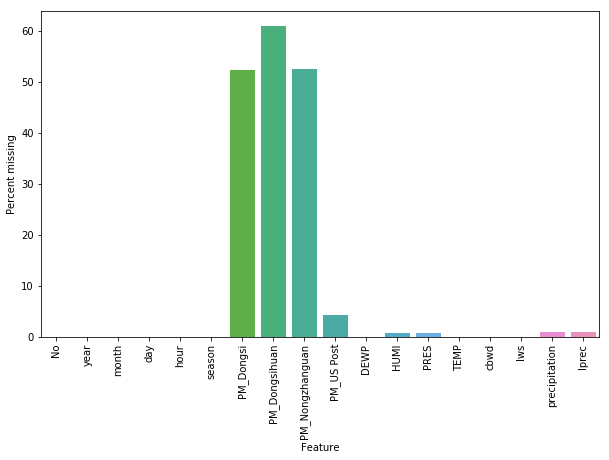

In [5]:
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (10,6))
plt.xticks(rotation=90)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [6]:
# drop the largest amount of null column among 2 PM locations and useless index column 
df = df.drop(["No","PM_Nongzhanguan","PM_Dongsihuan"],axis = 1)

In [7]:
# drop any rows with null value
df=df.dropna(axis=0, how="any")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null float64
PM_US Post       23951 non-null float64
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null object
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.9+ MB


## 2.3 Encoding Categorical Features

In [9]:
# change "cv"" in cbwd to "SW"
# This is a type from original dataset
df['cbwd'] = df['cbwd'].replace('cv', 'SW')
df['cbwd'].value_counts()

SE    8454
NW    7082
SW    5481
NE    2934
Name: cbwd, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["cbwd"] = enc.fit_transform(df["cbwd"])

In [11]:
df.head()

,year,month,day,hour,season,PM_Dongsi,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
26694,2013,1,17,6,4,25.0,34.0,-17.0,56.0,1038.0,-10.0,1,4.92,0.0,0.0
26695,2013,1,17,7,4,22.0,33.0,-16.0,52.0,1039.0,-8.0,0,4.92,0.0,0.0
26696,2013,1,17,8,4,20.0,33.0,-16.0,45.0,1040.0,-6.0,0,8.94,0.0,0.0
26697,2013,1,17,9,4,24.0,34.0,-16.0,38.0,1040.0,-4.0,0,12.07,0.0,0.0
26698,2013,1,17,10,4,27.0,38.0,-16.0,35.0,1040.0,-3.0,0,16.09,0.0,0.0


In [12]:
# categorize the PM 2.5 into 6 categories
#    PM 2.5    -    Category
#   [0, 35]            1
#   (35, 75]           2
#  (75, 115]           3
# (115, 150]           4
# (150, 250]           5
# (250 -               6
df["PM_US Post"] = pd.cut(df["PM_US Post"],[-1,35,75,115,150,250,float("inf")],labels=[1,2,3,4,5,6])
df["PM_Dongsi"] = pd.cut(df["PM_Dongsi"],[-1,35,75,115,150,250,float("inf")],labels=[1,2,3,4,5,6])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null category
PM_US Post       23951 non-null category
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null int64
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: category(2), float64(7), int64(6)
memory usage: 2.6 MB


In [14]:
print(df.PM_Dongsi.cat.categories)

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')


In [15]:
df['PM_Dongsi']= df['PM_Dongsi'].astype('int64')
df['PM_US Post']= df['PM_US Post'].astype('int64')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null int64
PM_US Post       23951 non-null int64
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null int64
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: float64(7), int64(8)
memory usage: 2.9 MB


In [17]:
df.head()

,year,month,day,hour,season,PM_Dongsi,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
26694,2013,1,17,6,4,1,1,-17.0,56.0,1038.0,-10.0,1,4.92,0.0,0.0
26695,2013,1,17,7,4,1,1,-16.0,52.0,1039.0,-8.0,0,4.92,0.0,0.0
26696,2013,1,17,8,4,1,1,-16.0,45.0,1040.0,-6.0,0,8.94,0.0,0.0
26697,2013,1,17,9,4,1,1,-16.0,38.0,1040.0,-4.0,0,12.07,0.0,0.0
26698,2013,1,17,10,4,1,2,-16.0,35.0,1040.0,-3.0,0,16.09,0.0,0.0


### 2.4 Corelation plot

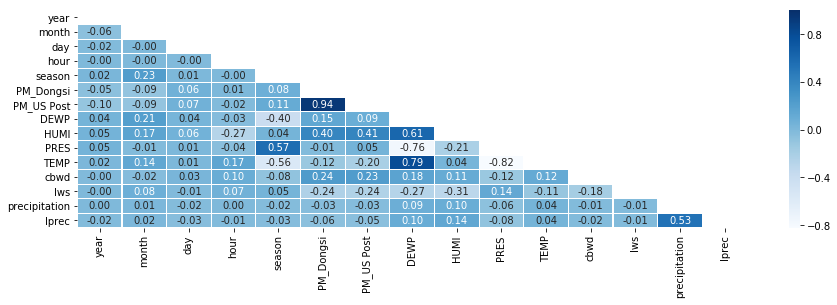

In [18]:
fig,ax = plt.subplots(figsize=(15,4))
mask=np.zeros_like(df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(df.corr(),mask=mask,ax=ax,annot=True, linewidths=0.1, fmt='.2f',cmap="Blues")
plt.show()

PM_Dongsi, HUMI(Humidity), cbwd(Combined wind direction), lws(Cumulated wind speed) and TEMP(Temperature) are important to the result of PM_US Post

### 2.5 Converting the data to X and Y

In [19]:
Y = df["PM_US Post"]
X = df.drop("PM_US Post", axis=1)

### 2.6 Splitting the data into train, validation and test sets

In [20]:
from sklearn.model_selection import train_test_split
X_train_val,X_test,Y_train_val,Y_test = train_test_split(X,Y,test_size = 0.12, random_state=666)
print(X_train_val.shape, Y_train_val.shape, X_test.shape, Y_test.shape)

(21076, 14) (21076,) (2875, 14) (2875,)


### 2.7 Feature Selection

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [22]:
clf=ExtraTreesClassifier()
clf=clf.fit(X_train_val,Y_train_val)
clf.feature_importances_

array([0.03213498, 0.03814884, 0.05917781, 0.05980965, 0.01785717,
       0.41372672, 0.06554268, 0.07406561, 0.06046679, 0.05825395,
       0.04744097, 0.06348819, 0.004581  , 0.00530566])

In [23]:
model=SelectFromModel(clf,threshold=0.04,prefit=True)
model.transform(X_train_val)
feature_idx=model.get_support()
feature_name=X_train_val.columns[feature_idx]

In [24]:
print(feature_name)

Index(['day', 'hour', 'PM_Dongsi', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd',
       'Iws'],
      dtype='object')


In [25]:
X_fs = df[list(feature_name)]
X_train_val_fs,X_test_fs,Y_train_val,Y_test = train_test_split(X_fs,Y,test_size = 0.12, random_state=666)
print(X_train_val_fs.shape, Y_train_val.shape, X_test_fs.shape, Y_test.shape)

(21076, 9) (21076,) (2875, 9) (2875,)


In [26]:
X_train_fs,X_val_fs,Y_train,Y_val = train_test_split(X_train_val_fs,Y_train_val,test_size = 0.14, random_state=666)
print(X_train_fs.shape, Y_train.shape, X_val_fs.shape, Y_val.shape)

(18125, 9) (18125,) (2951, 9) (2951,)


In [27]:
X_train_val_fs.describe()

,day,hour,PM_Dongsi,DEWP,HUMI,PRES,TEMP,cbwd,Iws
count,21076.000000,21076.000000,21076.000000,21076.000000,21076.000000,21076.000000,21076.000000,21076.000000,21076.000000
mean,15.730167,11.483678,2.620374,2.394952,53.406529,1016.187607,13.448852,1.686563,20.377491
std,8.829016,6.920458,1.595659,13.919481,25.827299,10.149563,11.611807,0.957593,46.084172
min,1.000000,0.000000,1.000000,-40.000000,2.000000,991.000000,-15.000000,0.000000,0.450000
25%,8.000000,5.000000,1.000000,-9.000000,31.000000,1008.000000,3.000000,1.000000,1.790000
50%,16.000000,11.000000,2.000000,3.000000,54.000000,1016.000000,15.000000,2.000000,4.920000
75%,23.000000,17.000000,4.000000,15.000000,76.000000,1024.000000,23.000000,2.000000,18.320000
max,31.000000,23.000000,6.000000,26.000000,100.000000,1043.000000,40.000000,3.000000,490.380000


# 3 Model Selection

### 3.1 Function Definition

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [30]:
def model_selection(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train,y_train)
    y_test_pred=clf.predict(x_test)
    score=clf.score(x_test,y_test)
    mae=mean_absolute_error(y_test,y_test_pred)
    r2=r2_score(y_test,y_test_pred)
    print("Model Evaluation over Test Data \nAccuracy Score: %f;  Mean Absolute Error: %f;  R**2 Score: %f" %(score,mae,r2))
    cfm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cfm, normalize = False, target_names = ['1','2','3','4','5','6'],title = "Confusion Matrix over Test Data")

In [31]:
def test_grid_search(clf, x_test, y_test):
    y_test_pred=clf.predict(x_test)
    score=clf.score(x_test,y_test)
    mae=mean_absolute_error(y_test,y_test_pred)
    r2=r2_score(y_test,y_test_pred)
    print("Model Evaluation over Test Data After Grid Search \nAccuracy Score: %f;  Mean Absolute Error: %f;  R**2 Score: %f" %(score,mae,r2))
    cfm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cfm, normalize = False, target_names = ['1','2','3','4','5','6'],title = "Confusion Matrix over Test Data")

### 3.2 KNN

In [32]:
from sklearn import neighbors
KNN_clf = KNeighborsClassifier()

Model Evaluation over Test Data 
Accuracy Score: 0.565913;  Mean Absolute Error: 0.660522;  R**2 Score: 0.509904


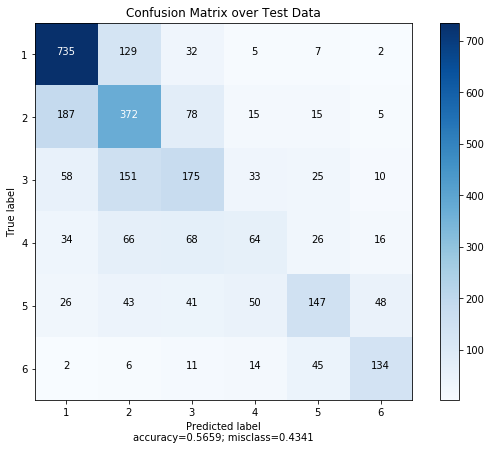

In [33]:
model_selection(KNN_clf, X_train_fs, Y_train,X_test_fs,Y_test)

##### 3.2.1 KNN GridSearch

In [34]:
param_grid = [
    {
    'weights':['uniform'],
    'n_neighbors':[i for i in range(1,10)]
    },
    {
    'weights':['distance'],
    'n_neighbors':[i for i in range(1,10)],
    'p':[i for i in range(1,3)]
    }
]

In [35]:
KNN_clf_grid = KNeighborsClassifier()
grid_search_knn = GridSearchCV(KNN_clf_grid, param_grid=param_grid,n_jobs=-1)
grid_search_knn.fit(X_train_val_fs,Y_train_val)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'weights': ['distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'p': [1, 2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
grid_search_knn.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Model Evaluation over Test Data After Grid Search 
Accuracy Score: 0.699826;  Mean Absolute Error: 0.395478;  R**2 Score: 0.753318


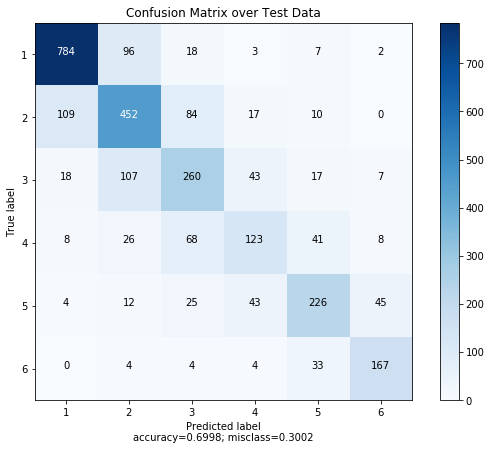

In [37]:
best_knn_clf=grid_search_knn.best_estimator_
test_grid_search(best_knn_clf, X_test_fs, Y_test)

### 3.3 Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

Model Evaluation over Test Data 
Accuracy Score: 0.766957;  Mean Absolute Error: 0.259130;  R**2 Score: 0.879077


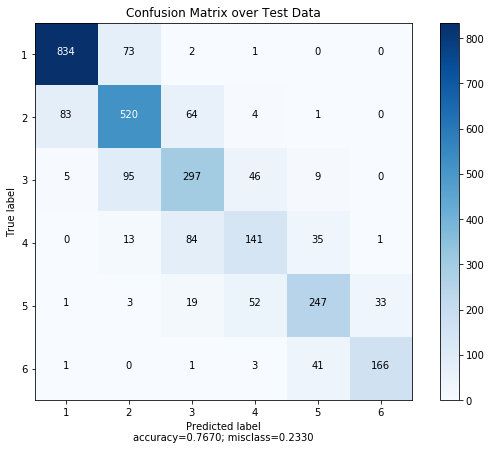

In [39]:
rf_clf=RandomForestClassifier(n_jobs = -1,bootstrap = True, random_state=666)
model_selection(rf_clf,X_train_fs, Y_train,X_test_fs,Y_test)

##### 3.3.1 Random Forest GridSearch

In [40]:
param_grid = [
    {
        'max_depth': [i for i in range(1,6)],
        'n_estimators': [i for i in range(80,130)],
        'bootstrap': [True],
        'random_state': [666]
    }
]

In [41]:
rf_clf_grid = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_clf_grid,param_grid,cv=3,n_jobs=-1)
grid_search_rf.fit(X_train_val_fs,Y_train_val)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5], 'n_estimators': [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], 'bootstrap': [True], 'random_state': [666]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Model Evaluation over Test Data After Grid Search 
Accuracy Score: 0.735304;  Mean Absolute Error: 0.296696;  R**2 Score: 0.859730


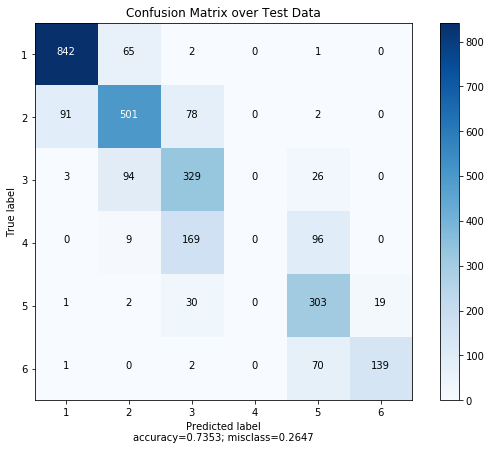

In [42]:
best_rf_clf=grid_search_rf.best_estimator_
test_grid_search(best_rf_clf, X_test_fs, Y_test)

### 3.4 Gradient Boosting

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

Model Evaluation over Test Data 
Accuracy Score: 0.759304;  Mean Absolute Error: 0.260174;  R**2 Score: 0.882607


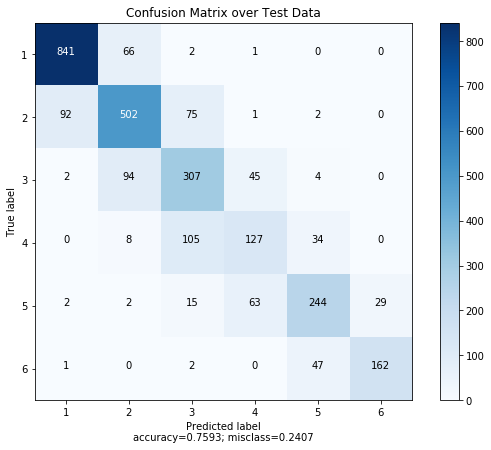

In [44]:
gb_clf = GradientBoostingClassifier(random_state=666)
model_selection(gb_clf, X_train_fs, Y_train,X_test_fs,Y_test)

##### 3.4.1 Gradient Boosting GridSearch

In [45]:
param_grid = [
    {
        'max_features': [i for i in range(1,4)],
        'max_depth': [i for i in range(1,5)],
        'n_estimators':[i for i in range(20,35)],
        'random_state': [666]
    }
]

In [46]:
gb_clf_grid = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb_clf_grid,param_grid,cv=3,n_jobs=-1)
grid_search_gb.fit(X_train_val_fs,Y_train_val)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_features': [1, 2, 3], 'max_depth': [1, 2, 3, 4], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 'random_state': [666]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
grid_search_gb.best_params_

{'max_depth': 4, 'max_features': 3, 'n_estimators': 34, 'random_state': 666}

Model Evaluation over Test Data After Grid Search 
Accuracy Score: 0.756522;  Mean Absolute Error: 0.265391;  R**2 Score: 0.879339


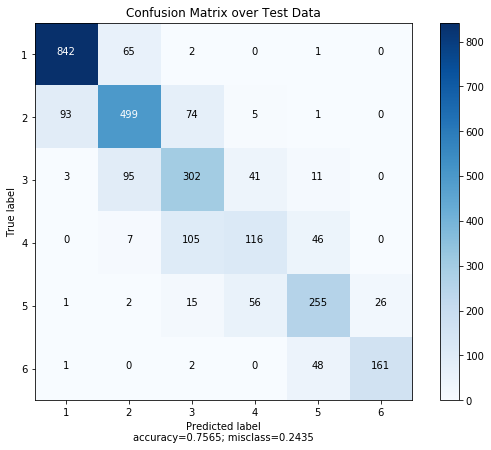

In [48]:
best_gd_clf=grid_search_gb.best_estimator_
test_grid_search(best_gd_clf, X_test_fs, Y_test)

# 4 Imbalanced learn

In [51]:
print(X_train_fs.shape, Y_train.shape)

(18125, 9) (18125,)


In [50]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_fs, Y_train)
from collections import Counter
print(sorted(Counter(Y_train_resampled).items()))
print(X_train_resampled.shape, Y_train_resampled.shape)

[(1, 5761), (2, 5761), (3, 5761), (4, 5761), (5, 5761), (6, 5761)]
(34566, 9) (34566,)


In [53]:
X_train_val_resampled, Y_train_val_resampled = ros.fit_resample(X_train_val_fs, Y_train_val)

## 4.1 Gradient Boosting

Model Evaluation over Test Data 
Accuracy Score: 0.756522;  Mean Absolute Error: 0.260870;  R**2 Score: 0.884960


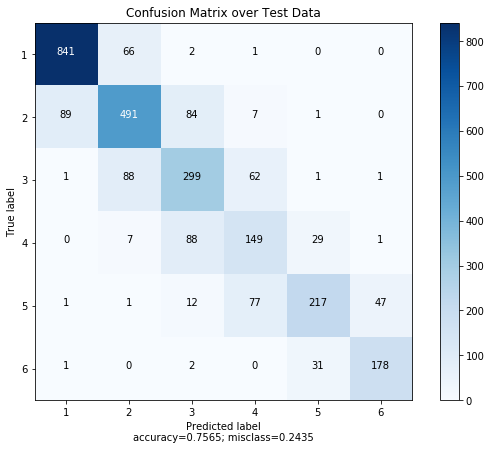

In [52]:
gb_clf_il = GradientBoostingClassifier(random_state=666)
model_selection(gb_clf_il, X_train_resampled, Y_train_resampled,X_test_fs,Y_test)

##### 4.4.1 Gradient Boosting GridSearch

In [54]:
param_grid = [
    {
        'max_features': [i for i in range(1,4)],
        'max_depth': [i for i in range(1,5)],
        'n_estimators':[i for i in range(20,35)],
        'random_state': [666]
    }
]

In [55]:
gb_clf_grid_il = GradientBoostingClassifier()
grid_search_gb_il = GridSearchCV(gb_clf_grid_il,param_grid,cv=3,n_jobs=-1)
grid_search_gb_il.fit(X_train_val_resampled,Y_train_val_resampled)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_features': [1, 2, 3], 'max_depth': [1, 2, 3, 4], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 'random_state': [666]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
grid_search_gb_il.best_params_

{'max_depth': 4, 'max_features': 3, 'n_estimators': 34, 'random_state': 666}

Model Evaluation over Test Data After Grid Search 
Accuracy Score: 0.754435;  Mean Absolute Error: 0.265739;  R**2 Score: 0.880254


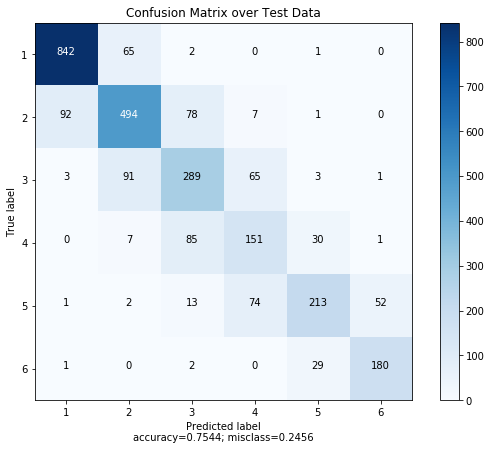

In [57]:
best_gd_clf_il=grid_search_gb_il.best_estimator_
test_grid_search(best_gd_clf_il, X_test_fs, Y_test)